<a href="https://colab.research.google.com/github/Emmanuel2000x/TelecomX-2/blob/main/TelecomX_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DESAFIO TELECOM X   PT. 2

## 🎯 Misión

Se busca desarrollar modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios.

La empresa quiere anticiparse al problema de la cancelación, y te corresponde a ti construir un pipeline robusto para esta etapa inicial de modelado.

##🧠 Objetivos del Desafío
* Preparar los datos para el modelado (tratamiento, codificación, normalización).
* Realizar análisis de correlación y selección de variables.
* Entrenar dos o más modelos de clasificación.
* Evaluar el rendimiento de los modelos con métricas.
* Interpretar los resultados, incluyendo la importancia de las variables.
* Crear una conclusión estratégica señalando los principales factores que influyen en la cancelación.

## 🛠️ Preparación de los Datos

In [179]:
# Importacion de librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [170]:
# Importación del modelo ya tratado anterioirmente
DF_clientes = pd.read_csv('/content/Datos_Mod_TelecomX.csv', index_col=0)
DF_clientes.reset_index()
DF_clientes.head()

,ID_Cliente,Cancelacion,Genero,Adulto_Mayor,Tiene_Pareja,Tiene_Dependientes,Meses_contratados,Servicio_Teléfono,Lineas_Multiples,Servicio_Internet,...,Proteccion_Dispositivo,Soporte_Tecnico,TV_Streaming,Peliculas_Streaming,Tipo_Contrato,Factura_Electronica,Metodo_Pago,Cargos_Mensuales,Cargos_Totales,Cargos_Diarios
0,0002-ORFBO,0,Female,0,1,1,9,1,0,DSL,...,0,1,1,0,One year,1,Mailed check,65.6,593.30,2.19
1,0003-MKNFE,0,Male,0,0,0,9,1,1,DSL,...,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.40,2.00
2,0004-TLHLJ,1,Male,0,0,0,4,1,0,Fiber optic,...,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85,2.46
3,0011-IGKFF,1,Male,1,1,0,13,1,0,Fiber optic,...,1,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85,3.27
4,0013-EXCHZ,1,Female,1,1,0,3,1,0,Fiber optic,...,0,1,1,0,Month-to-month,1,Mailed check,83.9,267.40,2.80


In [171]:
#Columnas del DF y su tipo de dato
DF_clientes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID_Cliente              7032 non-null   object 
 1   Cancelacion             7032 non-null   int64  
 2   Genero                  7032 non-null   object 
 3   Adulto_Mayor            7032 non-null   int64  
 4   Tiene_Pareja            7032 non-null   int64  
 5   Tiene_Dependientes      7032 non-null   int64  
 6   Meses_contratados       7032 non-null   int64  
 7   Servicio_Teléfono       7032 non-null   int64  
 8   Lineas_Multiples        7032 non-null   int64  
 9   Servicio_Internet       7032 non-null   object 
 10  Seguridad_En_Linea      7032 non-null   int64  
 11  Respaldo_En_Linea       7032 non-null   int64  
 12  Proteccion_Dispositivo  7032 non-null   int64  
 13  Soporte_Tecnico         7032 non-null   int64  
 14  TV_Streaming            7032 non-null   int64

In [172]:
# Eliminacion de columnas irrelevantes
# Se elimina el ID de los clientes que no tiene utilidad
DF_clientes.drop(columns='ID_Cliente',inplace=True)
# Se convierten los valores de genero de Female:0 y Male:1
DF_clientes['Genero'] = DF_clientes['Genero'].map({'Female':0, 'Male':1})

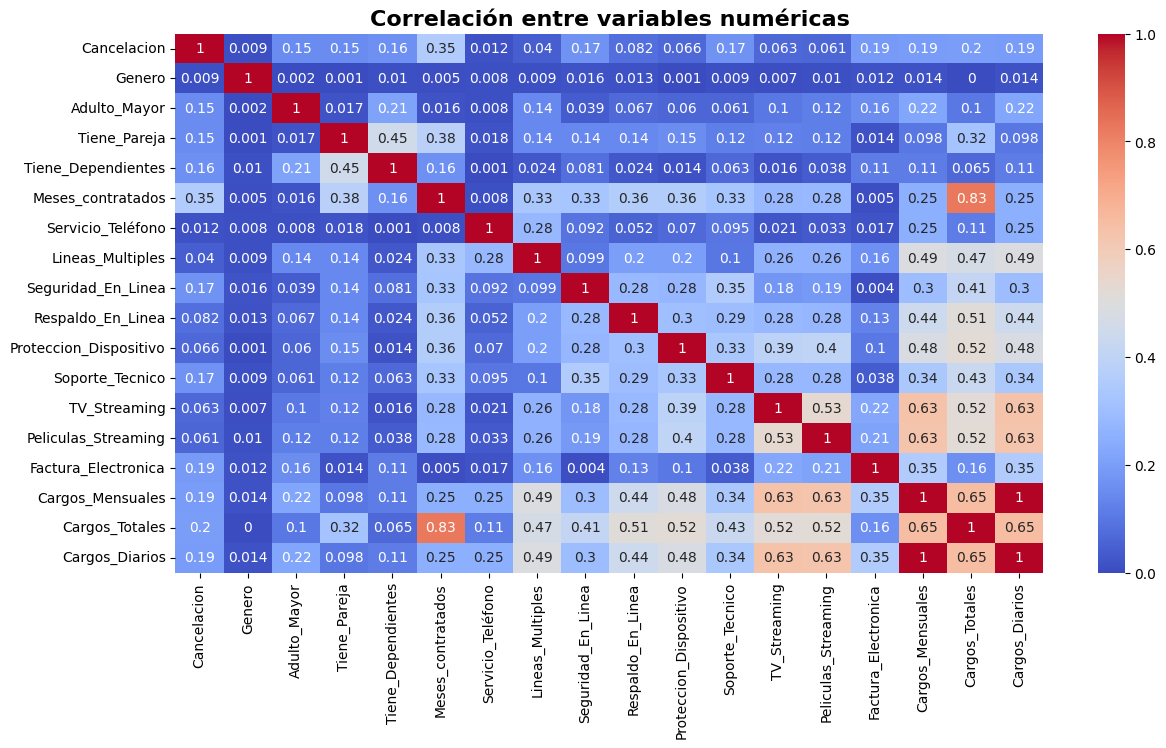

In [132]:
# Observamos si exite correlacion entre las variables numericas
plt.figure(figsize=(14,7))
sns.heatmap(DF_clientes.corr(numeric_only=True).round(3).abs(), annot=True, cmap="coolwarm")
plt.title("Correlación entre variables numéricas", fontsize=16, weight='bold', ha='center')
plt.show()

In [133]:
#Se observa que la variables Genero y Servicio_Teléfono no tienen casi relacion
#con churn, ademas la variable de Cargos_Diarios mantiene una fuerte
#correlacion con Cargos_Mensuales por lo que se eliminaran
DF_clientes.drop(columns= ['Genero','Servicio_Teléfono','Cargos_Diarios'],inplace=True)

In [134]:
#Verificación de la Proporción de Cancelación (Churn)
cancel_p = DF_clientes.value_counts(subset='Cancelacion',normalize=True)
print(f'Clientes que cancelaron: {round(cancel_p[1]*100,1)}% \nClientes que no cancelaron: {round(cancel_p[0]*100,1)}%')


Clientes que cancelaron: 26.6% 
Clientes que no cancelaron: 73.4%


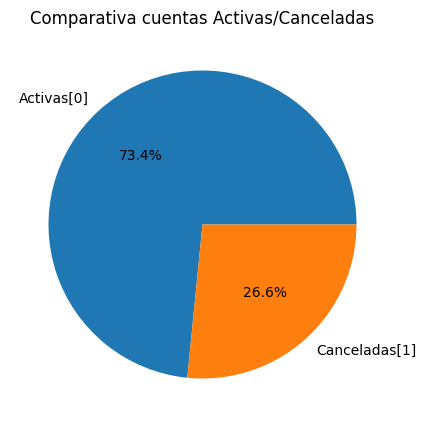

In [135]:
total_churn = DF_clientes['Cancelacion'].value_counts()
estados = ['Activas[0]', 'Canceladas[1]']
plt.figure(figsize=(5,5))
plt.pie(total_churn, labels=estados, autopct='%1.1f%%')
plt.title('Comparativa cuentas Activas/Canceladas')
plt.show()

### Encoding

In [136]:
# Separamos las columnas si son categoricas o numericas
col_categoricas = ['Servicio_Internet','Tipo_Contrato','Metodo_Pago']
col_numericas = ['Cargos_Mensuales','Cargos_Totales','Meses_contratados']

In [137]:
# Importamos los recursos para aplicar el OHE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer

In [138]:
OHE = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore',sparse_output=False),col_categoricas),
    remainder='passthrough')

encode_ohe = OHE.fit_transform(DF_clientes)
lista = OHE.get_feature_names_out()
DF_clientes_enc = pd.DataFrame(encode_ohe,
                               columns = OHE.get_feature_names_out())
DF_clientes_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 25 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   onehotencoder__Servicio_Internet_DSL                  7032 non-null   float64
 1   onehotencoder__Servicio_Internet_Fiber optic          7032 non-null   float64
 2   onehotencoder__Servicio_Internet_No                   7032 non-null   float64
 3   onehotencoder__Tipo_Contrato_Month-to-month           7032 non-null   float64
 4   onehotencoder__Tipo_Contrato_One year                 7032 non-null   float64
 5   onehotencoder__Tipo_Contrato_Two year                 7032 non-null   float64
 6   onehotencoder__Metodo_Pago_Bank transfer (automatic)  7032 non-null   float64
 7   onehotencoder__Metodo_Pago_Credit card (automatic)    7032 non-null   float64
 8   onehotencoder__Metodo_Pago_Electronic check           7032

In [139]:
# Create transformer
preprocessor = make_column_transformer(
    (OneHotEncoder(), col_categoricas),
    (StandardScaler(), col_numericas),
    remainder = 'passthrough'
    )
# Fit and transform
transformed_array = preprocessor.fit_transform(DF_clientes)
# Create new DataFrame
DF_clientes_encS = pd.DataFrame(
    transformed_array,
    columns = preprocessor.get_feature_names_out()
    )

DF_clientes_encS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 25 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   onehotencoder__Servicio_Internet_DSL                  7032 non-null   float64
 1   onehotencoder__Servicio_Internet_Fiber optic          7032 non-null   float64
 2   onehotencoder__Servicio_Internet_No                   7032 non-null   float64
 3   onehotencoder__Tipo_Contrato_Month-to-month           7032 non-null   float64
 4   onehotencoder__Tipo_Contrato_One year                 7032 non-null   float64
 5   onehotencoder__Tipo_Contrato_Two year                 7032 non-null   float64
 6   onehotencoder__Metodo_Pago_Bank transfer (automatic)  7032 non-null   float64
 7   onehotencoder__Metodo_Pago_Credit card (automatic)    7032 non-null   float64
 8   onehotencoder__Metodo_Pago_Electronic check           7032

## 🎯 Correlación y Selección de Variables

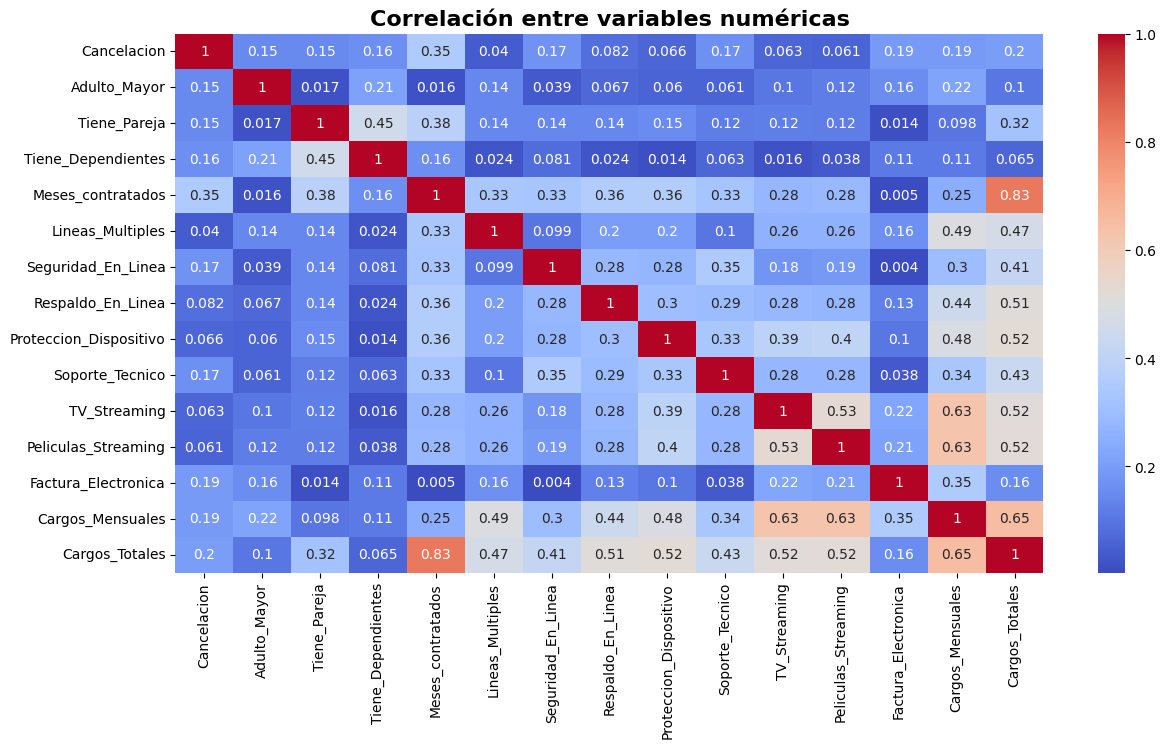

In [140]:
#Observamos si exite correlacion entre las variables numericas
plt.figure(figsize=(14,7))
sns.heatmap(DF_clientes.corr(numeric_only=True).round(3).abs(), annot=True, cmap="coolwarm")
plt.title("Correlación entre variables numéricas", fontsize=16, weight='bold', ha='center')
plt.show()

In [141]:
variables_corr = DF_clientes.corr(numeric_only=True).round(3).abs()
sorted_corr = (
    variables_corr.unstack()            # Make it a Series with (col1, col2) as index
    .drop_duplicates()               # Remove duplicates (A,B) and (B,A)
    .sort_values(ascending=False)    # Sort high to low
)
print(sorted_corr)


Cancelacion          Cancelacion            1.000
Meses_contratados    Cargos_Totales         0.826
Cargos_Mensuales     Cargos_Totales         0.651
TV_Streaming         Cargos_Mensuales       0.630
Peliculas_Streaming  Cargos_Mensuales       0.627
                                            ...  
Adulto_Mayor         Tiene_Pareja           0.017
                     Meses_contratados      0.016
Tiene_Pareja         Factura_Electronica    0.014
Meses_contratados    Factura_Electronica    0.005
Seguridad_En_Linea   Factura_Electronica    0.004
Length: 92, dtype: float64


In [142]:
DF_clientes.corr(numeric_only=True)['Cancelacion'].round(3).abs().sort_values(ascending=False)

,Cancelacion
Cancelacion,1.000
Meses_contratados,0.354
Cargos_Totales,0.199
Cargos_Mensuales,0.193
Factura_Electronica,0.191
Seguridad_En_Linea,0.171
Soporte_Tecnico,0.165
Tiene_Dependientes,0.163
Adulto_Mayor,0.151
Tiene_Pareja,0.150


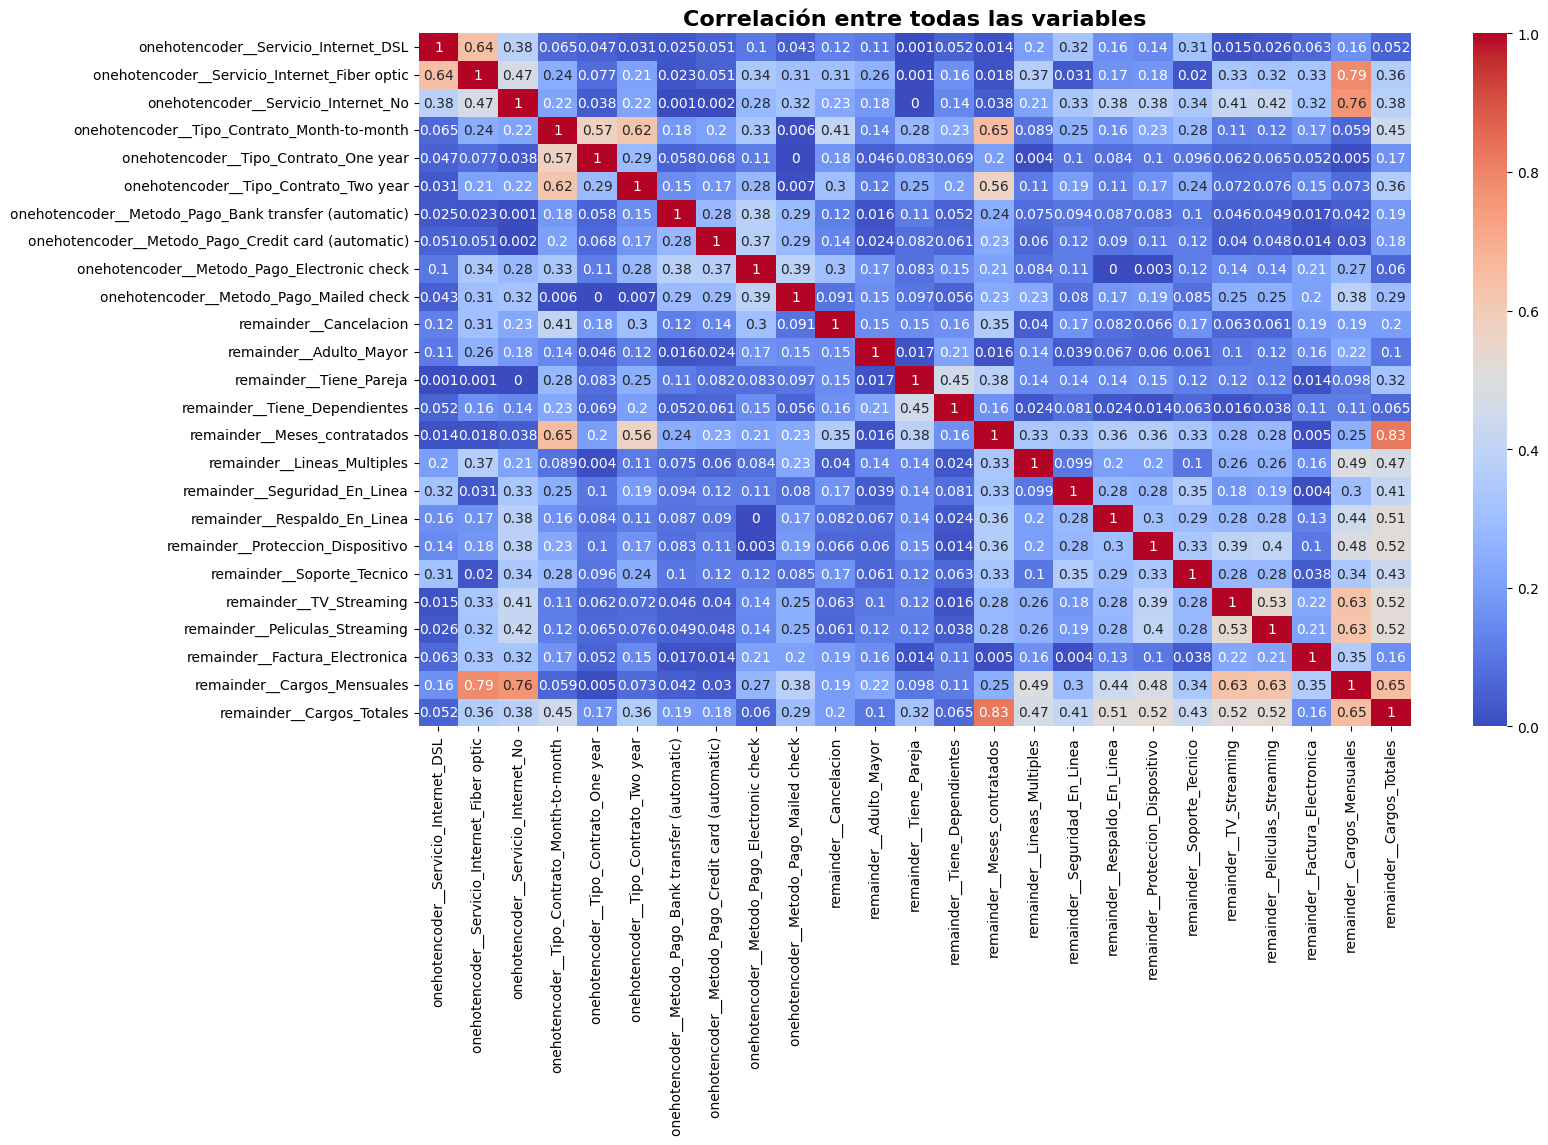

In [143]:
#Observamos si exite correlacion entre las variables numericas
plt.figure(figsize=(16,9))
sns.heatmap(DF_clientes_enc.corr(numeric_only=True).round(3).abs(), annot=True, cmap="coolwarm")
plt.title("Correlación entre todas las variables", fontsize=16, weight='bold', ha='center')
plt.show()

In [144]:
DF_clientes_enc.corr()['remainder__Cancelacion'].round(3).abs().sort_values(ascending=False)


,remainder__Cancelacion
remainder__Cancelacion,1.000
onehotencoder__Tipo_Contrato_Month-to-month,0.405
remainder__Meses_contratados,0.354
onehotencoder__Servicio_Internet_Fiber optic,0.307
onehotencoder__Tipo_Contrato_Two year,0.302
onehotencoder__Metodo_Pago_Electronic check,0.301
onehotencoder__Servicio_Internet_No,0.228
remainder__Cargos_Totales,0.199
remainder__Cargos_Mensuales,0.193
remainder__Factura_Electronica,0.191


## Análisis Dirigido

In [145]:
DF_clientes.head(7)

,Cancelacion,Adulto_Mayor,Tiene_Pareja,Tiene_Dependientes,Meses_contratados,Lineas_Multiples,Servicio_Internet,Seguridad_En_Linea,Respaldo_En_Linea,Proteccion_Dispositivo,Soporte_Tecnico,TV_Streaming,Peliculas_Streaming,Tipo_Contrato,Factura_Electronica,Metodo_Pago,Cargos_Mensuales,Cargos_Totales
0,0,0,1,1,9,0,DSL,0,1,0,1,1,0,One year,1,Mailed check,65.6,593.30
1,0,0,0,0,9,1,DSL,0,0,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.40
2,1,0,0,0,4,0,Fiber optic,0,0,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85
3,1,1,1,0,13,0,Fiber optic,0,1,1,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85
4,1,1,1,0,3,0,Fiber optic,0,0,0,1,1,0,Month-to-month,1,Mailed check,83.9,267.40
5,0,0,0,1,9,0,DSL,0,0,0,1,1,1,Month-to-month,1,Credit card (automatic),69.4,571.45
6,0,1,1,0,71,0,Fiber optic,1,1,1,1,1,1,Two year,1,Bank transfer (automatic),109.7,7904.25


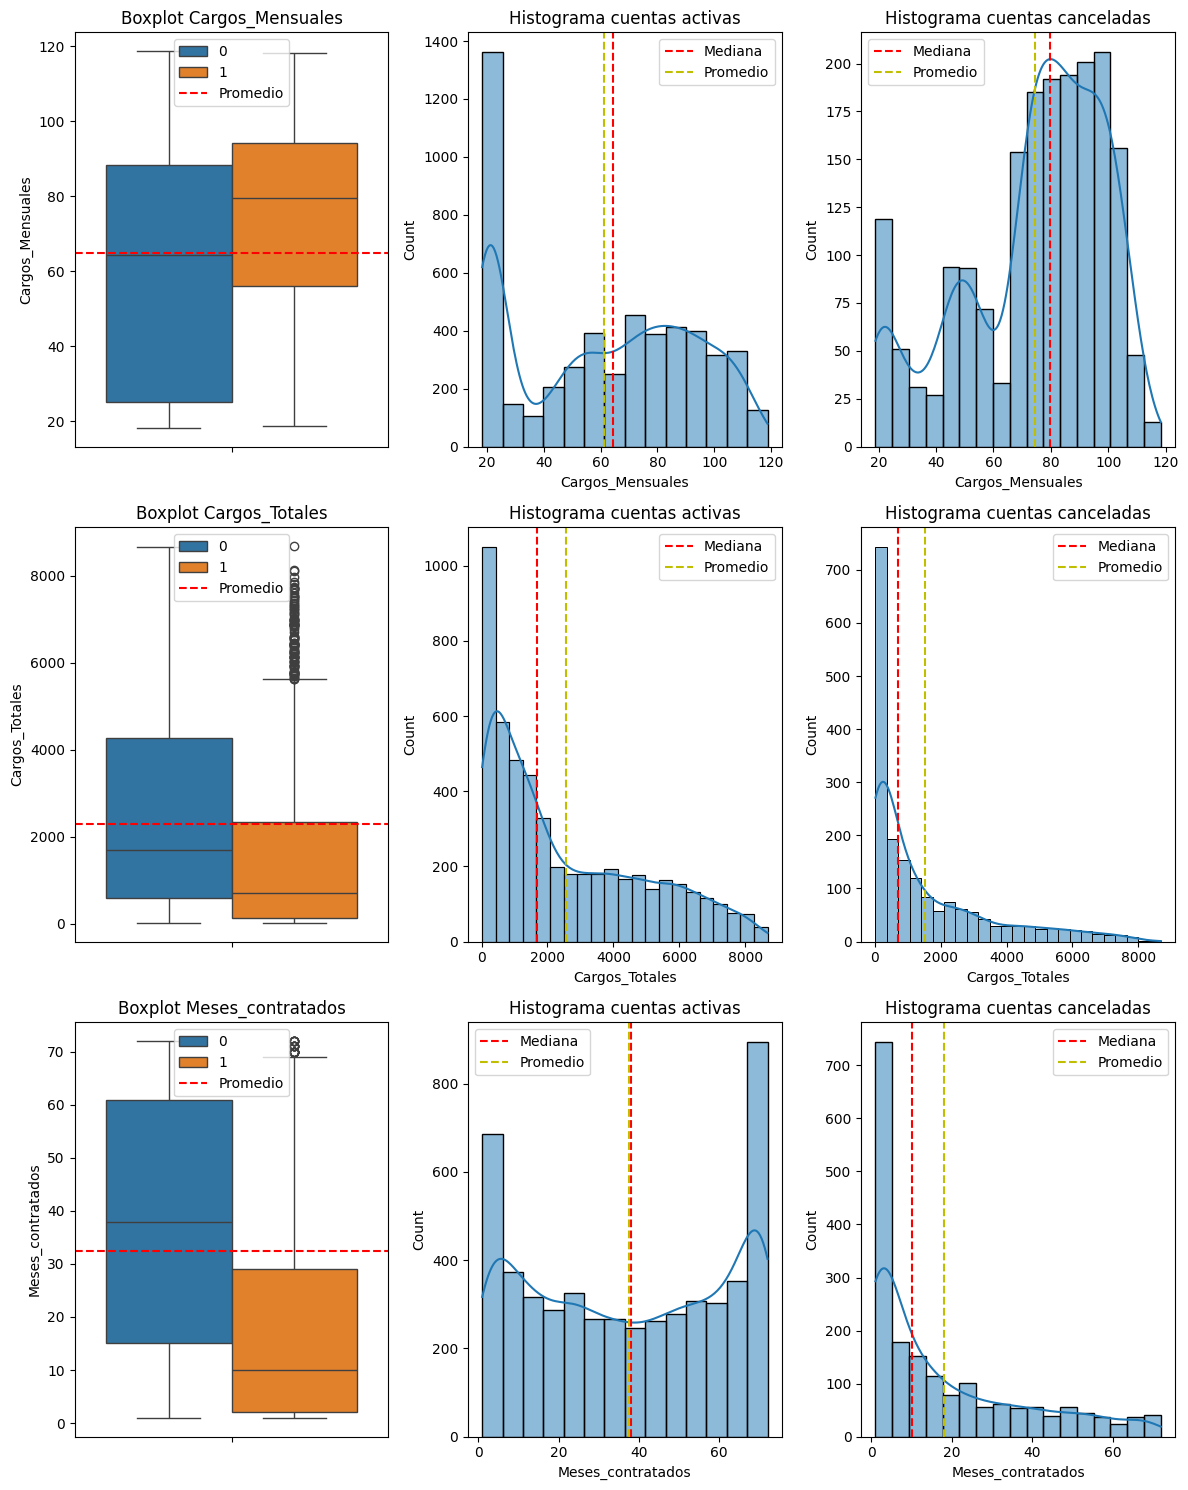

In [146]:
fig, ax = plt.subplots(3,3,figsize=(12,15))

for i,col in enumerate(col_numericas):
  mean_cancel = DF_clientes.loc[DF_clientes['Cancelacion'] == 1, col].mean()
  median_cancel = DF_clientes.loc[DF_clientes['Cancelacion'] == 1, col].median()
  mean_activ = DF_clientes.loc[DF_clientes['Cancelacion'] == 0, col].mean()
  median_activ = DF_clientes.loc[DF_clientes['Cancelacion'] == 0, col].median()
  avg = DF_clientes[col].mean()

  ax[i,0].set_title(f'Boxplot {col}')
  sns.boxplot(data = DF_clientes,
              y = col, hue = 'Cancelacion',
              ax = ax[i,0])
  ax[i,0].axhline(y=avg, color = 'r', linestyle='--',label='Promedio')
  ax[i,0].legend(loc='upper center')

  ax[i,1].set_title('Histograma cuentas activas')
  sns.histplot(x = DF_clientes.loc[DF_clientes['Cancelacion'] == 0, col],
                ax = ax[i,1],
                kde = True)
  plt.grid(False)
  ax[i,1].axvline(x=median_activ,color = 'r', linestyle='--',label='Mediana')
  ax[i,1].axvline(x=mean_activ,color = 'y', linestyle='--',label='Promedio')
  ax[i,1].legend()

  ax[i,2].set_title('Histograma cuentas canceladas')
  sns.histplot(x = DF_clientes.loc[DF_clientes['Cancelacion'] == 1, col],
            ax = ax[i,2],
            kde = True)
  plt.grid(False)
  ax[i,2].axvline(x=median_cancel,color = 'r', linestyle='--',label='Mediana')
  ax[i,2].axvline(x=mean_cancel,color = 'y', linestyle='--',label='Promedio')
  ax[i,2].legend()

plt.tight_layout()
plt.show()

In [147]:
DF_clientes_enc['remainder__Meses_contratados'].mean()

np.float64(32.421786120591584)

##Separacion de los datos

###Selecion de una parte de los datos para una prueba final

In [148]:
from sklearn.model_selection import train_test_split
#Seleccion de las variables descriptivas y la objetivo apartir del DF original
X = DF_clientes_enc.drop(columns='remainder__Cancelacion')
y = DF_clientes_enc.remainder__Cancelacion
#Separacion del 20% de los datos originales
X_train, X_prueba, y_train, y_prueba = train_test_split(X, y, test_size=0.2, random_state=100)

In [149]:
y.value_counts(normalize=True).round(3)

,proportion
remainder__Cancelacion,
0.0,0.734
1.0,0.266


###Balanceo de los datos a entrenar

In [150]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X_train, y_train)

In [151]:
y_bal.value_counts(normalize=True).round(3)

,proportion
remainder__Cancelacion,
0.0,0.5
1.0,0.5


###Division de los datos para entrenar para una validacion cruzada

In [152]:
from sklearn.model_selection import StratifiedKFold, cross_validate
SKF = StratifiedKFold(n_splits=5,shuffle=True,random_state=5)

##Entrenamiento

In [153]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

model_XGB = XGBClassifier()
model_LG = LogisticRegression()
model_DTC = DecisionTreeClassifier()

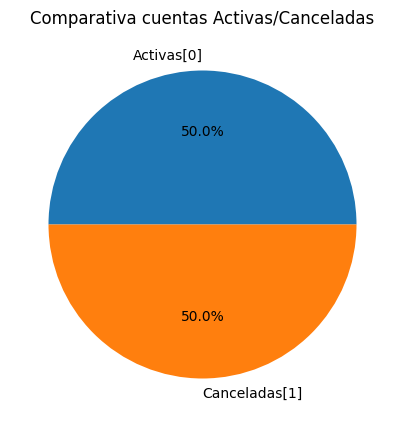

In [154]:
balanceo = y_bal.value_counts()
estados = ['Activas[0]', 'Canceladas[1]']
plt.figure(figsize=(5,5))
plt.pie(balanceo, labels=estados, autopct='%1.1f%%')
plt.title('Comparativa cuentas Activas/Canceladas')
plt.show()

## Evaluacion de los modelos

In [155]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

In [156]:
def evaluar_modelo(y_test, y_pred):
  print("Resultados para el modelo:")
  print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
  print(f"Precision: {precision_score(y_test, y_pred):.2f}")
  print(f"Recall: {recall_score(y_test, y_pred):.2f}")
  print(f"F1: {f1_score(y_test, y_pred):.2f}")

def informe_metricas(resultados):
  for metrica in ['test_accuracy', 'test_recall', 'test_precision', 'test_f1']:
    media = resultados[metrica].mean()
    desvio_estandar = resultados[metrica].std()
    print(f'Intervalo de confianza({metrica}): [{media-2*desvio_estandar}, {min(media+2*desvio_estandar, 1.0)}]')

In [157]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

In [158]:
# 1. Creacion del pipeline inicial
pipe = Pipeline([
    ('scaler', StandardScaler()),   # Scalado necesario para unos modelos
    ('model', LogisticRegression()) # Modelo Inicial
])

# 2. Modelos y su configuracion a probar
param_grid = [
    # Logistic Regression
    {
        'model': [LogisticRegression(max_iter=1000)],
        'model__C': [0.1, 1, 10], # Regularization strength
        'model__penalty': ['l2'],
        'model__solver': ['lbfgs']
    },
    # Random Forest
    {
        'scaler': ['passthrough'],  # Modelo no cuenta con scaler
        'model': [RandomForestClassifier(random_state=42)],
        'model__n_estimators': [100, 200],
        'model__max_depth': [5,7,10],
        'model__min_samples_split': [2, 5]
    },
    # Gradient Boosting
    {
        'scaler': ['passthrough'],
        'model': [GradientBoostingClassifier(random_state=42)],
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.05, 0.1]
    },
    # Support Vector Machine
    {
        'model': [SVC()],
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf']
    }
]

# 3. Creacion del GridSearchCV
grid = GridSearchCV(
    pipe,
    param_grid,
    cv = 5,
    scoring = ['recall','f1','accuracy','precision'],
    refit='f1',
    n_jobs=-1, #Se usaran todos los nucleos
    return_train_score=True
)

In [159]:
# 4. Fit
grid.fit(X_bal, y_bal)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'model': [LogisticRegression(max_iter=1000)],
                          'model__C': [0.1, 1, 10], 'model__penalty': ['l2'],
                          'model__solver': ['lbfgs']},
                         {'model': [RandomForestClassifier(random_state=42)],
                          'model__max_depth': [5, 7, 10],
                          'model__min_samples_split'...
                          'model__n_estimators': [100, 200],
                          'scaler': ['passthrough']},
                         {'model': [GradientBoostingClassifier(random_state=42)],
                          'model__learning_rate': [0.05, 0.1],
                          'model__n_estimators': [100, 200],
                          'scaler': ['passthrough']},
                         {'model': [SVC()], 'model__C': [0.1, 1, 10],
                          'model__kernel': ['linear', 'rbf']}],
             refit='f1', return_train_score=True,
             scoring=['recall', 'f1', 'accuracy', 'precision'])

In [173]:
# 5. Best results
print("Best Model Type:", type(grid.best_estimator_.named_steps['model']).__name__)
print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

Best Model Type: RandomForestClassifier
Best Parameters: {'model': RandomForestClassifier(random_state=42), 'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 200, 'scaler': 'passthrough'}
Best CV Accuracy: 0.8323816421965973


In [161]:
print(results_df.iloc[grid.best_index_][['params'] + metrics_cols])

params                 {'model': RandomForestClassifier(random_state=...
mean_test_recall                                                0.838411
mean_test_f1                                                    0.832382
mean_test_accuracy                                              0.844527
mean_test_precision                                             0.849562
Name: 12, dtype: object


In [163]:
# Se guarda el mejor modelo entrenado
best_model = grid.best_estimator_
# Se calcula la variable dependiente de la prueba
y_pred = best_model.predict(X_prueba)

In [180]:
# Codigo extrae los valores absolutos de importancia de cada variable
# independientemente del tipo de modelo
# Si el modelo tiene el atributo feature_importances_
from sklearn.inspection import permutation_importance
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_.abs().round(3)
    feat_importances = pd.DataFrame({
        'Variable': X.columns,
        'Importancia': importances
    }).sort_values(by='Importancia', ascending=False)
    print(feat_importances)
# Linear model
elif hasattr(best_model, 'coef_'):
    coef_importance = pd.DataFrame({
        'Variable': X.columns,
        'Importancia': abs(best_model.coef_[0].abs().round(3))
    }).sort_values(by='Importancia', ascending=False)
    print(coef_importance)
# Cualquier otro
else:
    result = permutation_importance(best_model, X, y, n_repeats=10, random_state=42)
    perm_importances = pd.DataFrame({
        'Variable': X.columns,
        'Importancia': np.abs(result.importances_mean)
    }).sort_values(by='Importancia', ascending=False)
    print(perm_importances)

                                             Variable  Importancia
3         onehotencoder__Tipo_Contrato_Month-to-month     0.025569
13                       remainder__Meses_contratados     0.022227
1        onehotencoder__Servicio_Internet_Fiber optic     0.017676
21                     remainder__Factura_Electronica     0.017477
23                          remainder__Cargos_Totales     0.015998
8         onehotencoder__Metodo_Pago_Electronic check     0.014804
22                        remainder__Cargos_Mensuales     0.012841
15                      remainder__Seguridad_En_Linea     0.009485
18                         remainder__Soporte_Tecnico     0.008646
2                 onehotencoder__Servicio_Internet_No     0.006086
14                        remainder__Lineas_Multiples     0.005944
19                            remainder__TV_Streaming     0.005560
12                      remainder__Tiene_Dependientes     0.005333
16                       remainder__Respaldo_En_Linea     0.00

In [174]:
evaluar_modelo(y_prueba,y_pred)

Resultados para el modelo:
Accuracy: 0.78
Precision: 0.58
Recall: 0.63
F1: 0.61


In [166]:
grid.best_estimator_.named_steps

{'scaler': 'passthrough',
 'model': RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)}

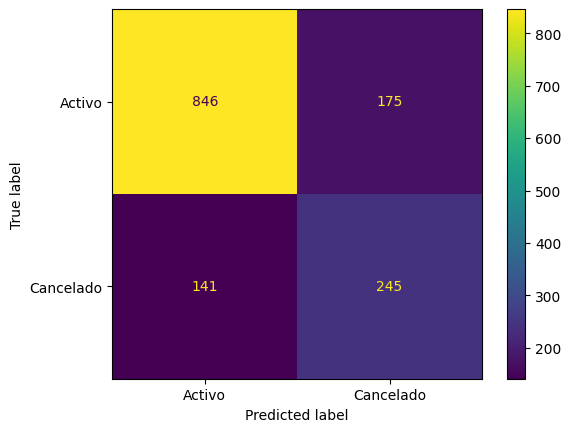

In [167]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

matriz_confusion = confusion_matrix(y_prueba,y_pred)
visualizacion_matriz = ConfusionMatrixDisplay(confusion_matrix = matriz_confusion, display_labels = ['Activo', 'Cancelado'])
visualizacion_matriz.plot();


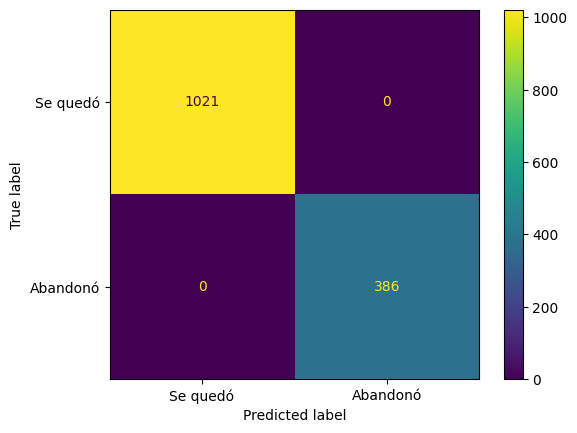

In [168]:
matriz_confusion = confusion_matrix(y_prueba,y_prueba)
visualizacion_matriz = ConfusionMatrixDisplay(confusion_matrix = matriz_confusion, display_labels = ['Se quedó', 'Abandonó'])
visualizacion_matriz.plot();
